In [4]:
import pydicom as dicom
import matplotlib.pylab as plt
import nibabel as nib
import SimpleITK as sitk
import numpy as np
import cv2
from enum import Enum


In [5]:
# interesting classes : 

# CLASS TO NUMBER
# (1) spleen
# (2) right kidney
# (3) left kidney
# (6) liver

class TAGS: 
    SPLEEN = 1
    RIGHT_KIDNEY = 2
    LEFT_KIDNEY = 3
    LIVER = 4


# MRI (CHAOS)
# Liver: 63 (55<<<70)
# Right kidney: 126 (110<<<135)
# Left kidney: 189 (175<<<200)
# Spleen: 252 (240<<<255) 

MRI_NUM_TO_TAG: dict = {
    252 : TAGS.SPLEEN,
    189: TAGS.RIGHT_KIDNEY,
    126 : TAGS.LEFT_KIDNEY,
    63: TAGS.LIVER
}


# CT - SYNAPSE (2015)
# (1) spleen
# (2) right kidney
# (3) left kidney
# (6) liver

CT_NUM_TO_TAG: dict = {
    1 : TAGS.SPLEEN,
    2 : TAGS.RIGHT_KIDNEY,
    3 : TAGS.LEFT_KIDNEY,
    6 : TAGS.LIVER
}


Start with MRI


TypeError: Image data of dtype object cannot be converted to float

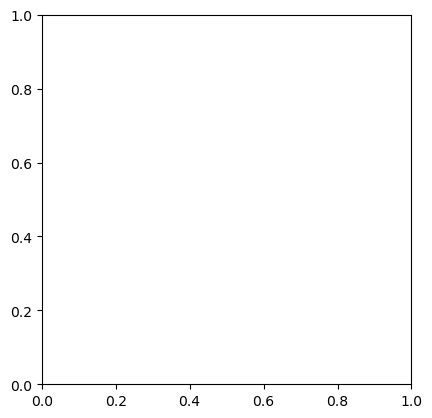

In [14]:
# specify your image path
mr_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/chaos/train/Train_Sets/MR/39/T1DUAL/DICOM_anon/InPhase/IMG-0027-00002.dcm'
mr_im = dicom.dcmread(mr_path)

gt_mr_path = '/users/scratch/baryaacovi-2024-06-01/projects/datasets/proto/chaos/train/Train_Sets/MR/39/T1DUAL/Ground/IMG-0027-00002.png'
gt_mr = cv2.imread(gt_mr_path)

plt.imshow(mr_im)

# plt.imshow(gt_mr)


done)


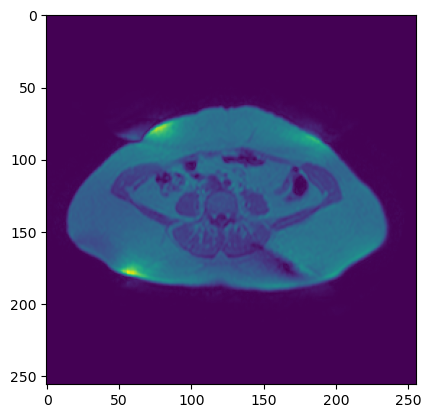

In [3]:
print("h")